# Train model

This notebook is to train the model.
1. First, some feature engineering is conducted to prepare the dataset and add the more details possible.
2. Then, a first model is trained using cross validation and expanding window validation to validate the model. The model and info are loaded to MLflow to store the different models and track the performances.
3. Finally, the best model is run on the entire train set.

# 1. Imports

## 1.1 Packages

In [11]:
import os
import pandas as pd
import sys

In [12]:
# Load custom functions
sys.path.append("../src/")
from prepare_data import get_holidays
from feature_engineering import extract_date_features, add_lockdown_periods, add_holidays_period,\
    get_split_train_val_cv
from train_model import train_model_cv_mlflow, train_model, create_pool

## 1.2 Options

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Define some parameters

path_data = "../data/processed"

feat_date = "Date"

## 1.3 Datasets

In [15]:
# Load the train set and its target

df_train = pd.read_pickle(os.path.join(path_data, "train.pkl"))
y_train = pd.read_csv(os.path.join(path_data, "target_train.csv"), index_col=0)

# 2. Prepare data

## 2.1 Feature engineering

To prepare data, the following feature engineering is done:
1. Extract info from date: year, month, day, day of the week and if its weekend or not
2. Add an indicator of the lockdown period: if there was a lockdown, and which one (first, second or thrid one)
3. Add holidays period for Zone A in France
4. Add holidays period for Zone B in France
5. Add holidays period for Zone C in France

(Having some geographical information could let us add just the right holidays period depending on the zone)

6. Drop columns Date and Fourni which will not be used in the model

In [16]:
df_train = df_train.pipe(extract_date_features, feat_date=feat_date)\
    .pipe(add_lockdown_periods, feat_date=feat_date)\
    .pipe(add_holidays_period, feat_date=feat_date, zone="Zone A")\
    .pipe(add_holidays_period, feat_date=feat_date, zone="Zone B")\
    .pipe(add_holidays_period, feat_date=feat_date, zone="Zone C")\
    .drop(columns=["Date", "Fourni"])

In [17]:
df_train

,id,Date_year,Date_month,Date_day,Date_weekday,Date_weekend,lockdown,Description_ZoneA,Description_ZoneB,Description_ZoneC
92,-6795017860123346820,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël
72,4324517785573311838,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël
71,5056562842583071429,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël
69,-5277685202972058648,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël
68,4079792561055568638,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël
...,...,...,...,...,...,...,...,...,...,...
64186,6858783929733742556,2022,6,20,0,0,0,None,None,None
64187,2132453013379446212,2022,6,20,0,0,0,None,None,None
64189,8884923748487096025,2022,6,20,0,0,0,None,None,None
64221,2942031581314612067,2022,6,20,0,0,0,None,None,None


In [18]:
# Define the categorical columns for the model
feat_cat = ["id", "Date_weekend", "lockdown", "Description_ZoneA", "Description_ZoneB", "Description_ZoneC"]

## 2.2 Split into folds

The train set is split into folds using expanding window validation. It means, we select one portion of the set as the train set, and the portion after as the validation. Then the validation set is added to the train set and a period after is the new validation set, and so on.

In [19]:
# Split the train set into different folds
list_train_valid = get_split_train_val_cv(df_train, y_train, n_splits=5)

# 3. Train model

## 3.1 Cross validation and hyperparameters search

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


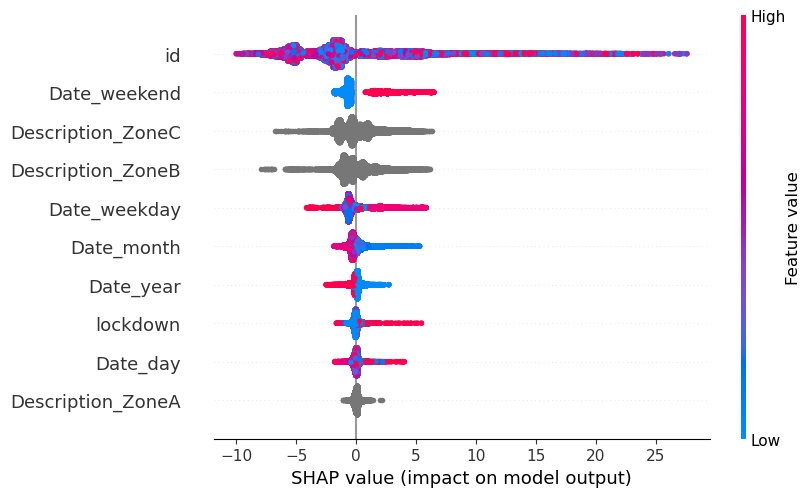

Setuptools is replacing distutils.


In [20]:
params = {
    "iterations": 1000,
    "depth": 7,
    "loss_function": "RMSE",
    "learning_rate": 0.07,
    "early_stopping_rounds": 100,
}

model, pred_train, pred_valid = train_model_cv_mlflow(
    list_train_valid=list_train_valid,
    feat_cat=feat_cat, plot_training=False, verbose=0,
    **params
)

## 3.2 Final model

In [21]:
params["iterations"] = model.get_best_iteration()

pool_train = create_pool(df_train, y_train, feat_cat=feat_cat)
model = train_model(pool_train=pool_train, pool_eval=None, plot_training=True, verbose=100, **params)

iteritems is deprecated and will be removed in a future version. Use .items instead.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 12.3888352	total: 25.1ms	remaining: 23.5s
100:	learn: 12.0638713	total: 1.76s	remaining: 14.6s
200:	learn: 12.0114101	total: 3.33s	remaining: 12.2s
300:	learn: 11.9687960	total: 4.98s	remaining: 10.5s
400:	learn: 11.9330976	total: 6.46s	remaining: 8.63s
500:	learn: 11.8856986	total: 8.06s	remaining: 7.01s
600:	learn: 11.8481215	total: 9.52s	remaining: 5.32s
700:	learn: 11.8143464	total: 11.4s	remaining: 3.84s
800:	learn: 11.7762862	total: 12.9s	remaining: 2.19s
900:	learn: 11.7451135	total: 14.4s	remaining: 575ms
936:	learn: 11.7342230	total: 14.9s	remaining: 0us
